**Name:** Byaravalli Arun Suhag

**EID:** 53265857

# CS4487 - Tutorial 8
## Non-Linear Dimensionality Reduction and Face Recognition

In this tutorial you will use non-linear dimensionality reduction on face images, and then train a classifier for face recognition.  You will then use manifold embedding to visualize the data.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import IPython.utils.warn as warn
random.seed(100)
rbow = plt.get_cmap('rainbow')

C:\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


## Loading Data and Pre-processing
We first need to load the images.  We will use the same dataset as Tutorial 7. Download `olivetti.pkz` from Canvas, and place it in in the same directory as this ipynb file.  _DO NOT UNZIP IT_.  Then run the following cell to load the images.

In [2]:
oli = datasets.fetch_olivetti_faces(data_home="./")
X = oli.data
Y = oli.target
img = oli.images
imgsize = oli.images[0].shape

Each image is a 64x64 array of pixel values, resulting in a 4096 dimensional vector.  Run the below code to show all the images!

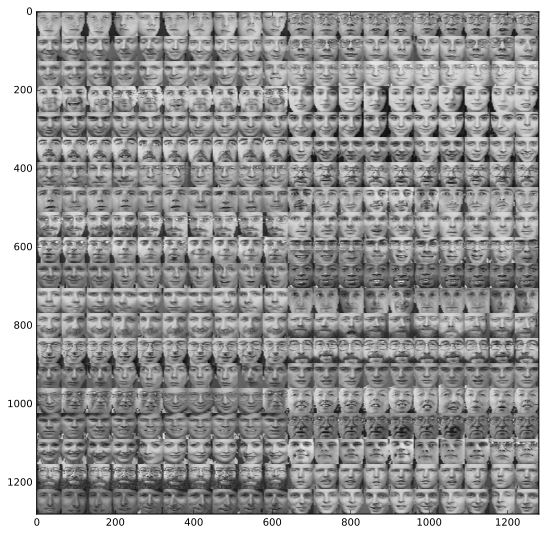

In [3]:
tmp = []
for i in range(0,400,20):
    tmp.append( hstack(img[i:i+20]) )
allimg = vstack(tmp)
plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.show()

Each person is considered as one class, and there are 10 images for each class.  In total there are 40 classes (people).  The data is already vectorized and put into the matrix `X`. Now we split the data into training and testing sets.

In [4]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  cross_validation.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print trainX.shape
print testX.shape

(320L, 4096L)
(80L, 4096L)


# Non-Linear Dimensionality Reduction - KPCA
The dimension of the data is too large (4096) so learning classifiers will take a long time.  Instead, our strategy is to use KPCA to reduce the dimension first and then use the KPCA weights as the representation for each image.  Run KPCA on the data using 10 principal components.  Use the RBF kernel with gamma=0.001.

In [8]:
### INSERT YOUR CODE HERE
# KPCA
kpca = decomposition.KernelPCA(n_components=10, kernel='rbf', gamma=0.001, degree=2, coef0=0)
W = kpca.fit_transform(trainX)

The below function will plot the basis vectors of KPCA. Run the next 2 cells to view the PCs.  The kernel PCs are a combination of similarities to points in the training set.  The PCs are visualized by showing the top 5 positive and negative training examples, along with their coefficient $\alpha_i$.

In [9]:
def plot_kbasis(model, imgsize, X):
    KK = model.n_components
    alphas = model.alphas_.T
    minmax = 5
    
    py = KK
    px = minmax*2
    for i in range(KK):
        # sort alphas
        inds = argsort(alphas[i,:])

        myi = r_[arange(-1,-minmax-1,-1), arange(minmax-1,-1,-1)]
        myinds = inds[myi]
        
        for j,jj in enumerate(myinds):
            plt.subplot(py,px,(j+1)+i*px)
            plt.imshow(X[jj,:].reshape(imgsize), interpolation='nearest')
            plt.gray()
            if alphas[i,jj]<0:
                mycol = 'b'
            else:
                mycol = 'r'
            plt.title("%0.3f" % (alphas[i,jj],), fontsize=7, color=mycol)
            if (j==0):
                plt.ylabel('PC' + str(i+1))
            plt.xticks([])
            plt.yticks([])

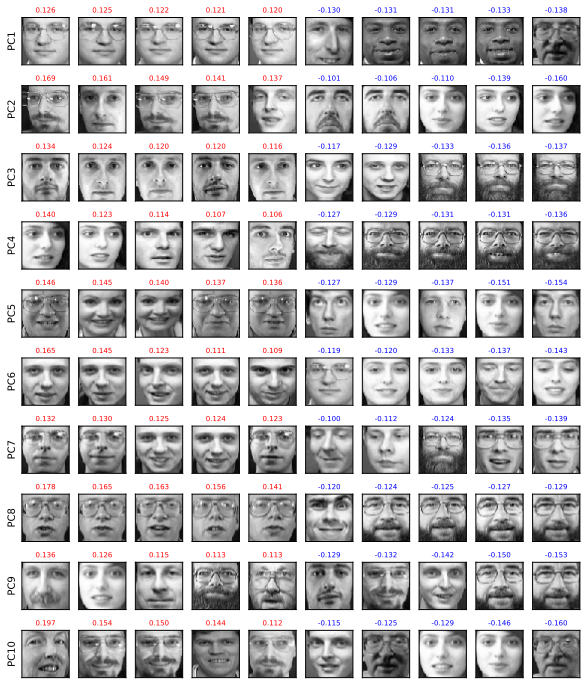

In [10]:
# run the function
plt.figure(figsize=(10,12))
plot_kbasis(kpca, imgsize, trainX)

_What is the interpretation for the KPCA basis?  What kind of faces do some of the PCs prefer?_
- ** Each kpca basis image look like a face, where the first five faces for each principal component represent the top 5 positive training examples and the next five faces represent the top 5 negative training examples. The n_components value has been set to 10, thus there are 10 principal components in the figure above.**

**it is hard to infer exactly what the PC prefer in terms of different faces, but some of the notable observations are stated as follows:**
- ** PC1 = Seems to prefer faces with spectacles (+ve and high $\alpha_i$), and seems to omit faces/pictures with a low brightness( -ve and low $\alpha_i$) **
- ** PC2 = Seems to prefer faces which cover the right side of the image and seem to be gazing to the left hand side of the screen (+ve and high $\alpha_i$) **
- ** PC4 = Seems to omit faces with beards ( -ve and low $\alpha_i$) **
- ** PC6 = Seems to omit feminine-looking faces ( -ve and low $\alpha_i$) **
- ** PC8 = Seems to prefer faces with beards (+ve and high $\alpha_i$) **
- ** For rest of the PC component basis = it is hard to comment on what exaclty it is looking for in the data set. **

### Face Recognition
Now train a _linear_ classifier to do the face recognition.  Use the calculated KPCA representation as the new set of inputs.  Use cross-validation to set the hyperparameters of the classifier.  You do not need to do cross-validation for the number of components or kernel hyperparameters.  Calculate the average training and testing accuracies.  Remember to transform the test data into the KPCA representation too!

**NOTE**: It is **NOT** recommended to use `svm.SVC` for the training.  This is because the default SVC implements 1-vs-1 multi-class classification, which means it will calculate 40x39=1560 classifiers!  All other classifier should be fine since they do 1-vs-all multi-class classification, e.g., LogisticRegressionCV, LinearSVC, etc.  If you want to use svm.SVC, make sure to use the OneVsRestClassifier as shown in Lecture 3.

### Linear SVC

In [11]:
# KPCA
kpca = decomposition.KernelPCA(n_components=10, kernel='rbf', gamma=0.001, degree=2, coef0=0)
W = kpca.fit_transform(trainX)
Wt  = kpca.transform(testX)     # use the kpca model to transform the test set

max_cp = 0
max_accp = 0
for c in range(1,200):
    #  cv is the number of folds
    svc = svm.LinearSVC(C=c, random_state = 4321)
    svc.fit(W, trainY)

    # predict from the model
    predY = svc.predict(Wt)

    # calculate accuracy
    Ncorrect = sum(testY==predY)
    acc      = mean(testY==predY)
    if acc > max_accp:
        max_accp = acc
        max_cp = c
    
print  max_cp
print max_accp

167
0.7875


### Logistic Regression

In [13]:
kpca = decomposition.KernelPCA(n_components=10, kernel='rbf', gamma=0.001, degree=2, coef0=0)
W = kpca.fit_transform(trainX)
Wt  = kpca.transform(testX)     # use the kpca model to transform the test set

logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5)
logreg.fit(W, trainY)
    

print "w=", logreg.coef_
print "b=", logreg.intercept_

w= [[  1.44767563e+01   1.33336884e+01   3.89677462e+00  -2.11336826e-01
   -2.71905881e+01  -1.31593567e+01   6.34262467e+00   2.95450021e+01
    1.02687546e+01   1.12480656e+01]
 [  2.00301858e+00  -6.51764405e+00   1.40296628e+01  -7.83839201e+00
   -7.84899125e+00  -6.28185925e+00  -1.53195879e+01   2.94362166e+01
   -5.75830714e+00   2.66707329e+00]
 [  3.28708386e+00  -3.90444558e+00  -2.13580970e+01  -1.49002832e+00
   -1.91601891e+00  -4.68254414e+00  -3.30416702e+01  -2.11915868e+01
    4.83782991e-01  -3.49444396e+01]
 [  5.90188322e-05   5.64117990e-06   1.82118596e-05  -6.24536367e-06
   -1.35369333e-05   5.95618437e-06  -6.93504258e-05   2.01361268e-05
   -2.12751303e-05   6.69766565e-06]
 [  5.96096899e+00   9.64867813e+00  -2.14126137e+01   1.15463832e+01
    5.23621127e+01  -3.93451843e+00   1.32707869e+01   3.39785717e+01
   -7.50036890e+00  -4.22329598e+01]
 [  1.72208839e+01  -1.10115310e+00   8.16316988e-01   1.15290338e+01
    2.15878280e+01  -1.03712568e+01  -8.11

test accuracy  = 0.725
C =  [  5.45559478e+02   2.06913808e+02   5.45559478e+02   1.00000000e-04
   1.43844989e+03   2.06913808e+02   2.06913808e+02   2.06913808e+02
   1.00000000e+04   5.45559478e+02   5.45559478e+02   1.43844989e+03
   1.43844989e+03   1.43844989e+03   3.79269019e+03   2.06913808e+02
   5.45559478e+02   5.45559478e+02   5.45559478e+02   5.45559478e+02
   1.00000000e-04   2.06913808e+02   1.43844989e+03   7.84759970e+01
   5.45559478e+02   1.43844989e+03   1.43844989e+03   1.00000000e+04
   5.45559478e+02   2.06913808e+02   2.06913808e+02   5.45559478e+02
   2.06913808e+02   2.06913808e+02   1.43844989e+03   5.45559478e+02
   7.84759970e+01   1.00000000e+04   1.43844989e+03   1.43844989e+03]


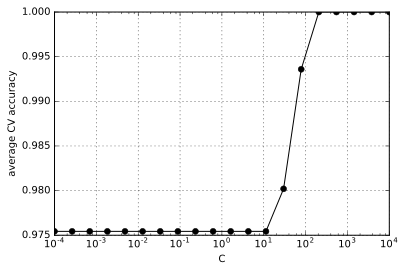

In [15]:
predYtest = logreg.predict(Wt)

# calculate accuracy
acc = metrics.accuracy_score(testY, predYtest)
print "test accuracy  =", acc

print "C = ", logreg.C_

# calculate the average score for each C
avgscores = mean(logreg.scores_[1],0)  # 1 is the class label
plt.figure()
plt.semilogx(logreg.Cs_, avgscores, 'ko-')
plt.xlabel('C'); plt.ylabel('average CV accuracy')
plt.grid(True);

### Finding the best kernel and best number of components
Now try different kernels (poly, RBF, etc), kernel parameters, and number of components to get the best test accuracy.  Train a classifier for each one and see which dimension gives the best testing accuracy.  Make a plots of number of components vs. test accuracy.

### Linear SVC

In [18]:
import decimal
max_np = 0
max_accp = 0
accuracies1 = []
kernel_types = ['rbf','linear','poly', 'sigmoid', 'cosine']
best_kernel = ''

for n in range(1,50):
    for p in kernel_types:
        # run KPCA
        kpca = decomposition.KernelPCA(n_components=n, kernel=p, gamma=0.001, degree=2, coef0=0)
        W = kpca.fit_transform(trainX) 
        Wt  = kpca.transform(testX)     # use the kpca model to transform the test set
        svc = svm.LinearSVC(C=max_cp)
        svc.fit(W, trainY)

        # predict from the model
        predY = svc.predict(Wt)

        # calculate accuracy
        Ncorrect = sum(testY==predY)
        acc      = mean(testY==predY)
        print 'ACCURACY=  ' + str(decimal.Decimal(acc).quantize(decimal.Decimal('.001'), rounding=decimal.ROUND_UP)), 'n value: ' + str(n), ' Kernel Type = ' + p
        if(acc > max_accp):
            max_accp = acc
            max_np = n
            best_kernel = p
            
print max_accp
print max_np
print best_kernel

ACCURACY=  0.063 n value: 1  Kernel Type = rbf
ACCURACY=  0.063 n value: 1  Kernel Type = linear
ACCURACY=  0.088 n value: 1  Kernel Type = poly
ACCURACY=  0.038 n value: 1  Kernel Type = sigmoid
ACCURACY=  0.088 n value: 1  Kernel Type = cosine
ACCURACY=  0.150 n value: 2  Kernel Type = rbf
ACCURACY=  0.125 n value: 2  Kernel Type = linear
ACCURACY=  0.101 n value: 2  Kernel Type = poly
ACCURACY=  0.163 n value: 2  Kernel Type = sigmoid
ACCURACY=  0.075 n value: 2  Kernel Type = cosine
ACCURACY=  0.263 n value: 3  Kernel Type = rbf
ACCURACY=  0.138 n value: 3  Kernel Type = linear
ACCURACY=  0.238 n value: 3  Kernel Type = poly
ACCURACY=  0.213 n value: 3  Kernel Type = sigmoid
ACCURACY=  0.276 n value: 3  Kernel Type = cosine
ACCURACY=  0.350 n value: 4  Kernel Type = rbf
ACCURACY=  0.125 n value: 4  Kernel Type = linear
ACCURACY=  0.363 n value: 4  Kernel Type = poly
ACCURACY=  0.350 n value: 4  Kernel Type = sigmoid
ACCURACY=  0.375 n value: 4  Kernel Type = cosine
ACCURACY=  0.500

### Logistic Regression

In [19]:
import decimal
max_np = 0
max_accp = 0
accuracies1 = []
kernel_types = ['rbf','linear','poly', 'sigmoid', 'cosine']
best_kernel = ''

for n in range(1,50):
    for p in kernel_types:
        # run KPCA
        kpca = decomposition.KernelPCA(n_components=n, kernel=p, gamma=0.001, degree=2, coef0=0)
        W = kpca.fit_transform(trainX) 
        Wt  = kpca.transform(testX)     # use the kpca model to transform the test set
        logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5)
        logreg.fit(W, trainY)

        # predict from the model
        predYtest = logreg.predict(Wt)

        acc = metrics.accuracy_score(testY, predYtest)
        print 'ACCURACY=  ' + str(decimal.Decimal(acc).quantize(decimal.Decimal('.001'), rounding=decimal.ROUND_UP)), 'n value: ' + str(n), ' Kernel Type = ' + p
        if(acc > max_accp):
            max_accp = acc
            max_np = n
            best_kernel = p
            
print max_accp
print max_np
print best_kernel

ACCURACY=  0.038 n value: 1  Kernel Type = rbf
ACCURACY=  0.038 n value: 1  Kernel Type = linear
ACCURACY=  0.038 n value: 1  Kernel Type = poly
ACCURACY=  0.026 n value: 1  Kernel Type = sigmoid
ACCURACY=  0.013 n value: 1  Kernel Type = cosine
ACCURACY=  0.051 n value: 2  Kernel Type = rbf
ACCURACY=  0.051 n value: 2  Kernel Type = linear
ACCURACY=  0.051 n value: 2  Kernel Type = poly
ACCURACY=  0.051 n value: 2  Kernel Type = sigmoid
ACCURACY=  0.051 n value: 2  Kernel Type = cosine
ACCURACY=  0.138 n value: 3  Kernel Type = rbf
ACCURACY=  0.150 n value: 3  Kernel Type = linear
ACCURACY=  0.150 n value: 3  Kernel Type = poly
ACCURACY=  0.138 n value: 3  Kernel Type = sigmoid
ACCURACY=  0.113 n value: 3  Kernel Type = cosine
ACCURACY=  0.288 n value: 4  Kernel Type = rbf
ACCURACY=  0.250 n value: 4  Kernel Type = linear
ACCURACY=  0.263 n value: 4  Kernel Type = poly
ACCURACY=  0.188 n value: 4  Kernel Type = sigmoid
ACCURACY=  0.125 n value: 4  Kernel Type = cosine
ACCURACY=  0.388

_What is the best kernel and number of components?  View the prototypes for each compenent to see what they look like_
- **Linear SVC**
   * RBF kernel with 25 components
- ** Logistic Regression**
    * poly kernel with 32 components

77
0.9625


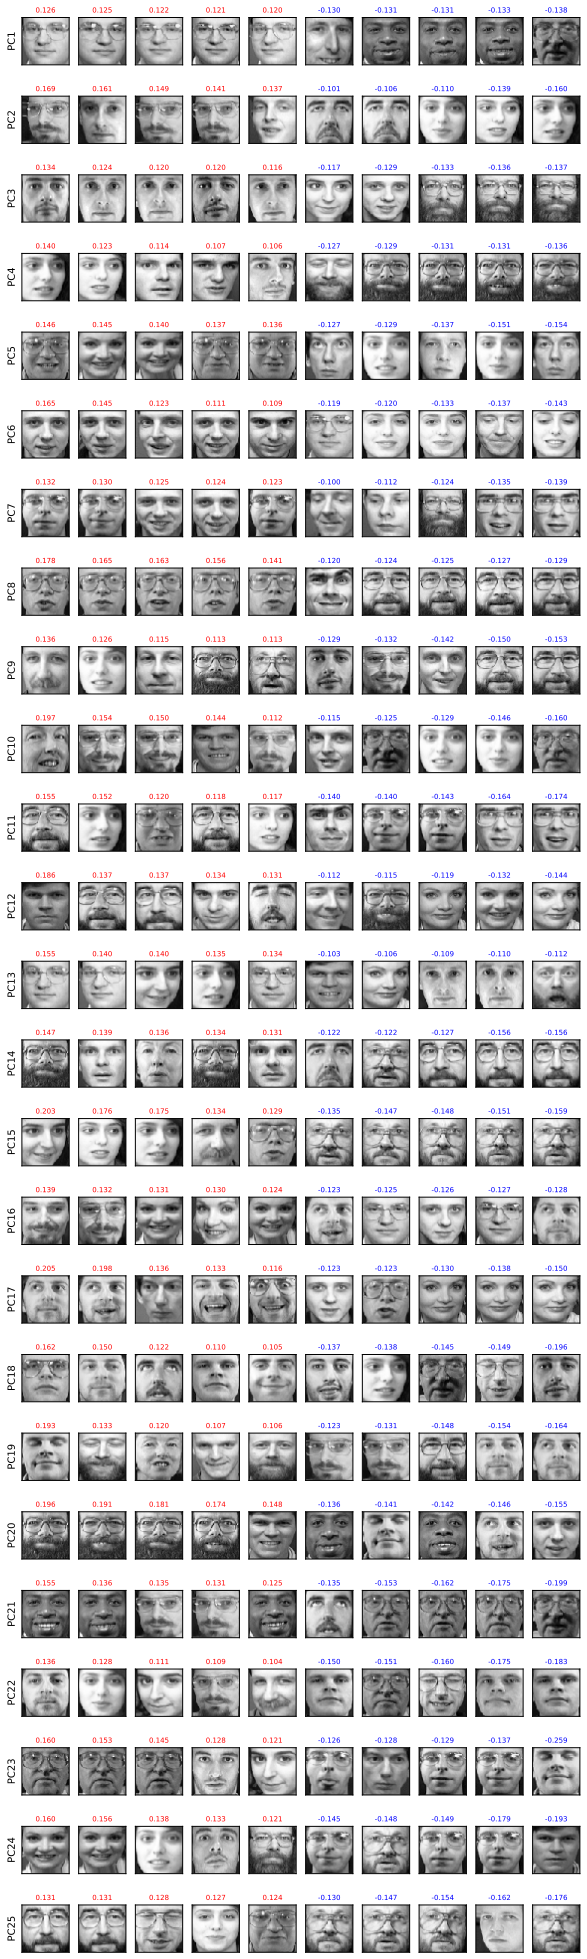

In [20]:
### INSERT YOUR CODE HERE
### Linear SVC 
# run KPCA
kpca = decomposition.KernelPCA(n_components=25, kernel='rbf', gamma=0.001, degree=2, coef0=0)
W = kpca.fit_transform(trainX)
Wt  = kpca.transform(testX)     # use the pca model to transform the test set
svc = svm.LinearSVC(C=max_cp)
svc.fit(W, trainY)

# predict from the model
predY = svc.predict(Wt)

# calculate accuracy
Ncorrect = sum(testY==predY)
acc      = mean(testY==predY)

print Ncorrect
print acc

# run the function
plt.figure(figsize=(10,35))
plot_kbasis(kpca, imgsize, trainX)

In [21]:
### Logistic regression
kpca = decomposition.KernelPCA(n_components=32, kernel='poly', gamma=0.001, degree=2, coef0=0)
W = kpca.fit_transform(trainX)
Wt  = kpca.transform(testX)     # use the kpca model to transform the test set

logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5)
logreg.fit(W, trainY)
    

print "w=", logreg.coef_
print "b=", logreg.intercept_

# run the function
plt.figure(figsize=(10,35))
plot_kbasis(kpca, imgsize, trainX)

w= [[  5.69807366   5.82619877   2.02160676 ...,  -1.2457861   -1.0925542
    3.83510158]
 [ -0.28643514  -3.83705747   8.80866481 ...,   3.42868604  -2.50830377
   -0.33817762]
 [  7.29545635  -9.05544236 -31.01036642 ..., -16.34601666 -10.88403039
  -21.41796031]
 ..., 
 [  1.11306778   1.80553973 -15.15519839 ...,  -2.57740968  -2.56546717
    6.91188305]
 [-15.70753829  -1.59482913   0.03385289 ...,   3.47545297  -9.0220756
   -3.37264365]
 [  5.16123584   2.48379536 -14.19757276 ..., -16.38417019   2.82105344
    3.98446746]]
b= [ -8.53326798  -6.22405086 -15.67541191  -6.02829057  -9.55075728
  -8.83894086  -9.52240924  -8.02361324 -12.41468722  -9.87041309
  -5.91213678  -9.12948247 -10.45746161  -5.93026603  -8.21497036
  -9.589121    -7.81451032  -7.91580805 -11.28579746  -6.94452568
  -9.57767056  -9.01637545 -14.52006722  -6.64766348  -8.28512014
  -6.05106816  -6.33094474  -6.9325391   -7.75591259  -9.255821
 -12.02000117  -9.1364657   -7.07062948  -7.99634265  -8.56465321


# Manifold embedding
Now you will use manifold embedding to visualize the dataset.
Use various methods to embed the data into 2 dimensions.  Use the below function to plot the low-dimensional data. **Note:** use the whole dataset `X` to do the embedding.

In [22]:
def plot_embedding(X, title=None):
    # X is the low-dim data
    zoomfact = 0.25  # change this to make images bigger/smaller
    
    x_min, x_max = amin(X, 0), amax(X, 0)
    X = (X - x_min) / (x_max - x_min)
    ax = plt.gca()

    plt.scatter(X[:,0], X[:,1], c=Y, cmap=rbow, edgecolor="")
    
    if hasattr(matplotlib.offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = array([[1., 1.]])  # just something big
        for i in range(img.shape[0]):
            dist = sum((X[i] - shown_images) ** 2, 1)
            if min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = r_[shown_images, [X[i]]]
            imagebox = matplotlib.offsetbox.AnnotationBbox(
                matplotlib.offsetbox.OffsetImage(img[i], 
                    zoom=zoomfact, 
                    cmap=plt.cm.gray), X[i], pad=0.02)
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

#### LOCAL LINEAR EMBEDDING

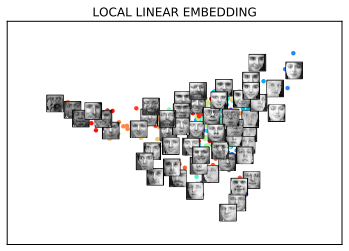

In [23]:
n_neighbors = 30 # This is my assumption
lle = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, random_state=121)
Xr = lle.fit_transform(X)
plot_embedding(Xr, 'LOCAL LINEAR EMBEDDING')

#### set method to 'hessian'

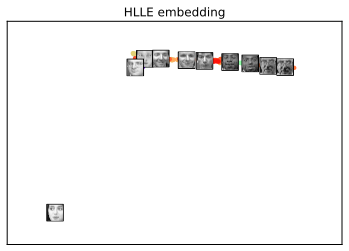

In [24]:
hlle = manifold.LocallyLinearEmbedding(method='hessian', n_neighbors=n_neighbors, n_components=2, random_state=121)
Xr = hlle.fit_transform(X)
plot_embedding(Xr, 'HLLE embedding')

#### set method to 'ltsa'

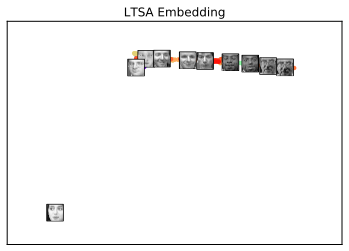

In [25]:
ltsa = manifold.LocallyLinearEmbedding(method='ltsa', n_neighbors=n_neighbors, n_components=2, random_state=121)
Xr = ltsa.fit_transform(X)
plot_embedding(Xr, 'LTSA Embedding')

#### Isometric Mapping

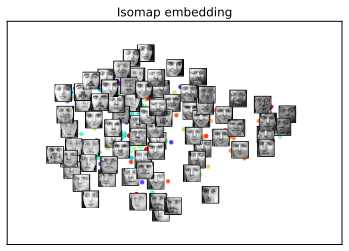

In [26]:
iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2)
Xr = iso.fit_transform(X)
plot_embedding(Xr, 'Isomap embedding')

#### Spectral Embedding

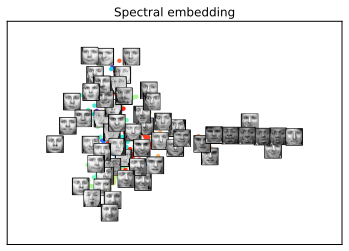

In [27]:
# using nearest-neighbors for affinity
spe = manifold.SpectralEmbedding(n_components=2, affinity='nearest_neighbors', 
                                 random_state=121, n_neighbors=n_neighbors)
Xr = spe.fit_transform(X)
plot_embedding(Xr, 'Spectral embedding')

#### Multi Dimensional Scaling

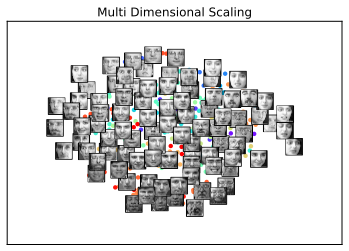

In [28]:
mds = manifold.MDS(n_components=2, random_state=121)
Xr = mds.fit_transform(X)
plot_embedding(Xr, 'Multi Dimensional Scaling')


#### t-Distributed Stochastic Neighbor Embedding 

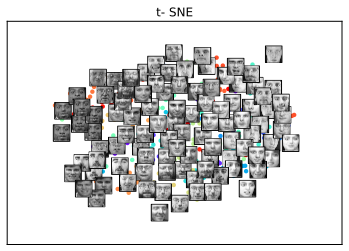

In [29]:
tsne = manifold.TSNE(n_components=2, perplexity=30.0, random_state=121)
Xr = tsne.fit_transform(X)
plot_embedding(Xr, 't- SNE')


_ Which embedding looks the best in terms of preserving structure of the data (similarity between images)?_
- **- By looking at the scatter plot of all the embeddings, it seems that t- Distributed Stochastic Neigbour Embedding looks the best in terms of preserving structure of the data**